In [9]:
# Basic Import

import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns 
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')

In [10]:
## loading dataset
df = pd.read_csv('stock_data.csv')

# convert date field from string to Date format 
df['Date'] = pd.to_datetime(df.Date)

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,59.687500,59.977501,59.180000,59.977501,59.741245,23753600
1,2020-01-03,58.775002,59.457500,58.525002,59.017502,58.785023,20538400
2,2020-01-06,58.080002,59.317501,57.817501,59.264999,59.031548,26263600
3,2020-01-07,59.549999,60.442501,59.097500,59.982498,59.746220,31485600
4,2020-01-08,59.939999,60.509998,59.537498,60.095001,59.858280,27710800


In [11]:
# preparing data for training

df1 = df[['Date','Adj Close']]

# Renaming Adj Close
df1.rename(columns={'Adj Close': 'AdjClose'}, inplace=True)
print("Shape of close dataframe:", df1.shape)

Shape of close dataframe: (1092, 2)


In [12]:
# Consider only last 1 year data for prediction

df1 = df1[df1['Date'] > '2023-02-18']
close_stock = df1.copy()
print("Total data for prediction: ",df1.shape[0])

Total data for prediction:  303


In [13]:
df1.head(2)

,Date,AdjClose
789,2023-02-21,206.448700
790,2023-02-22,207.438217


In [14]:
# Normalizing close price value

del df1['Date']
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
print(df1.shape)

(303, 1)


In [15]:
# Preparing train test data

training_size=int(len(df1)*0.70)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (212, 1)
test_data:  (91, 1)


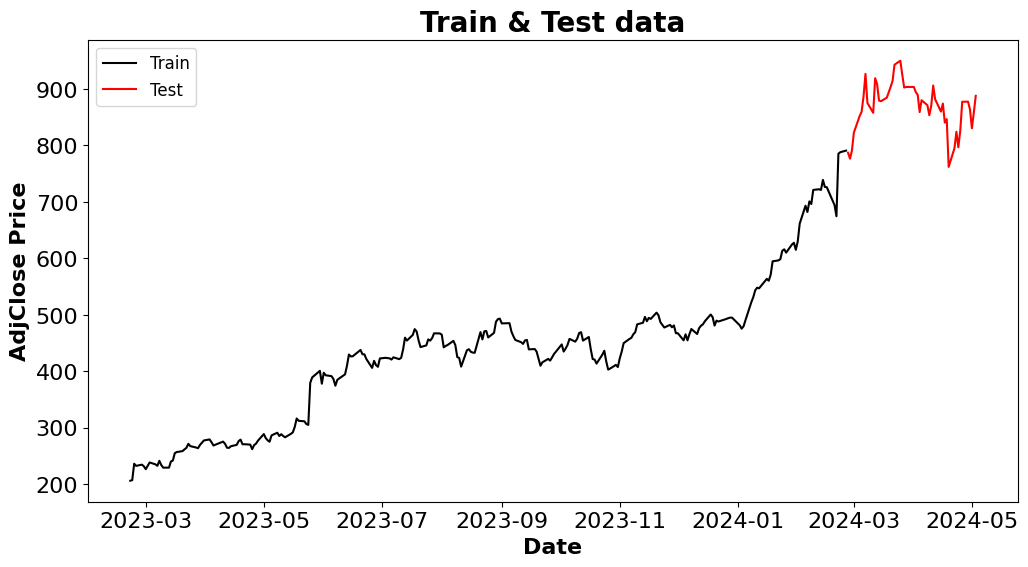

In [19]:
# Plotting train and test data for visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Plot train data
sns.lineplot(x=close_stock['Date'][:255], y=close_stock['AdjClose'][:255], color='black', label='Train')

# Plot test data
sns.lineplot(x=close_stock['Date'][255:], y=close_stock['AdjClose'][255:], color='red', label='Test')

# Formatting
ax.set_title('Train & Test data', fontsize=20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize=16, fontdict=dict(weight='bold'))
ax.set_ylabel('AdjClose Price', fontsize=16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

# Set legend
ax.legend(loc='upper left', fontsize=12)

plt.show()

In [20]:
# Prepare train data for time series analysis

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [21]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (196, 15)
y_train:  (196,)
X_test:  (75, 15)
y_test (75,)


In [23]:
# Import XGBRegressor module and Fit X_train and y_train for training model

# from xgboost import XGBRegressor
# my_model = XGBRegressor(n_estimators=1000)
# my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [29]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 500, 1000, 1500],
    'learning_rate': [0.001, 0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0, 1.5]
}

# Create the XGBoost model
xgb_model = XGBRegressor()

# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=xgb_model, 
                                   param_distributions=param_grid, 
                                   n_iter=50, 
                                   scoring='neg_mean_squared_error', 
                                   cv=5, 
                                   verbose=2, 
                                   n_jobs=-1, 
                                   random_state=42)

# Fit the random search model
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best parameters found: ", best_params)

# Train the model with the best parameters
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

# Evaluate the model
# y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Model testing and evaluation

In [30]:
predictions = my_model.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 0.4381260275740668
Root Mean squared Error - RMSE : 0.46242056654528024


In [31]:
train_predict=my_model.predict(X_train)
test_predict=my_model.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (196, 1)
Test data prediction: (75, 1)


In [32]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [33]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['AdjClose'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Close price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (303, 1)
Test predicted data:  (303, 1)
